# Transformación y Selección del Modelo
**Test 1 Prueba Data Science Capgemini**
**Javier Crespo Guerrero** (javicrespi2000@gmail.com)

Transformación de los datos a partir de los resultados del análisis exploratorio y selección del modelo posterior.

**PLANTEAMIENTO DEL PROBLEMA**

Los pasos a seguir serán los siguientes:
1. Construiremos una pipeline con las transformaciones, imputación de variables missing y codificaciones que definimos en el notebook anterior.
2. A partir de este primer pipeline, crearemos dos variantes: una que incluya las transformaciones Log y YeoJohnson para ciertas variables numéricas y otra que no las incluya.
3. Definiremos los modelos a considerar y las métricas de rendimiento.
4. Realizaremos un proceso de validación cruzada para comprobar el efecto de la transformación de las variables numéricas.
5. Dividiremos la muestra en train y test. Utilizaremos la muestra train para determinar los parámetros de los modelos considerados mediante validación cruzada y usaremos la muestra test para la comparación final entre modelos.
6. Seleccionaremos el modelo final en base a las métricas de rendimiento.

In [155]:
# Carga de dependencias

# manipulacion de datasets
import pandas as pd
import numpy as np

# visualizacion
import matplotlib.pyplot as plt

# procesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# para crear un nuevo transformador
from sklearn.base import BaseEstimator, TransformerMixin

# feature engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    OneHotEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

# modelos
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# evaluacion y metricas de rendimiento
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [ ]:
# Parametros a partir del analisis exploratorio

FILE_PATH = "../data/heart_disease_uci.csv"

RANDOM_SEED = 2024

TARGET = "num"

VARS_TO_DROP = ["id"]

CATEGORICAL_VARS = ["dataset", "sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

CATEGORICAL_VARS_TO_ENCODE = ["dataset", "sex", "cp", "restecg", "slope", "thal"]

CATEGORICAL_VARS_WITH_MISSING = ["fbs", "restecg", "exang", "slope", "thal"]

CATEGORICAL_VARS_TO_INPUTE_WITH_MOST_FREQ = ["fbs", "restecg", "exang"]

CATEGORICAL_VARS_TO_INPUTE_WITH_NEW_LABEL = ["slope", "thal"]

NUMERICAL_VARS = ["ca", "age", "thalch", "trestbps", "chol", "oldpeak"]

NUMERICAL_VARS_WITH_MISSING = ["ca", "thalch", "trestbps", "chol", "oldpeak"]

NUMERICAL_VARS_WITH_MISSING_MEAN_INPUTATION = ["thalch", "ca"]

NUMERICAL_VARS_WITH_MISSING_MEDIAN_INPUTATION = ["chol", "trestbps", "oldpeak"]

NUMERICAL_VARS_TO_REPLACE_CEROS = [
    "trestbps",
    "chol",
]  # Variables en las que contamos el 0 como dato missing

NUMERICAL_VARS_TO_LOG = (
    [  # Variables en las que estudiamos la transformacion logaritmica
        "chol",
        "trestbps",
    ]
)

NUMERICAL_VARS_TO_YEOJOHNSON = [
    "oldpeak"
]  # Variables en las que estudiamos la transformacion Yeo-Johnson

In [33]:
data = pd.read_csv(FILE_PATH)
print(data.shape)
data.head()

(920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [34]:
# Eliminamos la variable ID y separamos la variable objetivo
data.drop(VARS_TO_DROP, axis=1, inplace=True)

# Codificamos las variables categoricas como categoricas
data[CATEGORICAL_VARS] = data[CATEGORICAL_VARS].astype(object)

X = data.drop(TARGET, axis=1)
y = data[TARGET]

(X.shape, y.shape)

((920, 14), (920,))

## Pipeline del modelo

A continuación vamos a construir la pipeline básica con las transformaciones seleccionadas. Vamos a hacer dos versiones del Pipeline, una con las variables numéricas sin transformar y otra con las variables transformadas mediante el logaritmo y la transformación de Yeo-Johnson según vimos en el notebook anterior.

In [ ]:
# Clase para incorporar a la pipeline la conversion de 0 en None
class ReplaceZeroWithNone(BaseEstimator, TransformerMixin):
    def __init__(self, variables):

        if not isinstance(variables, list):
            raise ValueError("variables should be a list")

        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        for var in self.variables:
            X[var] = X[var].replace(0, None)

        return X

In [ ]:
# Comprobacion del nuevo replacer
replacer = ReplaceZeroWithNone(variables=NUMERICAL_VARS_TO_REPLACE_CEROS)
X_copy = X.copy()
X_copy_transformed = replacer.fit_transform(X_copy)

for var in NUMERICAL_VARS_TO_REPLACE_CEROS:
    assert len(X_copy_transformed[var][X_copy_transformed[var] == 0]) == 0

In [ ]:
heart_disease_pipe_base_steps = [
    # VARIABLES CATEGORICAS
    (
        "missing_indicator_categorical",
        AddMissingIndicator(variables=CATEGORICAL_VARS_WITH_MISSING),
    ),
    (
        "missing_imputation_new_label",
        CategoricalImputer(
            imputation_method="missing",
            variables=CATEGORICAL_VARS_TO_INPUTE_WITH_NEW_LABEL,
        ),
    ),
    (
        "missing_imputation_most_freq",
        CategoricalImputer(
            imputation_method="frequent",
            variables=CATEGORICAL_VARS_TO_INPUTE_WITH_MOST_FREQ,
        ),
    ),
    (
        "categorical_encoder",
        OneHotEncoder(drop_last=True, variables=CATEGORICAL_VARS_TO_ENCODE),
    ),
    # VARIABLES NUMERICAS
    ("cero_replacer", ReplaceZeroWithNone(variables=NUMERICAL_VARS_TO_REPLACE_CEROS)),
    (
        "missing_indicator_numerical",
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_MISSING),
    ),
    (
        "missing_imputation_mean",
        MeanMedianImputer(
            imputation_method="mean",
            variables=NUMERICAL_VARS_WITH_MISSING_MEAN_INPUTATION,
        ),
    ),
    (
        "missing_imputation_median",
        MeanMedianImputer(
            imputation_method="median",
            variables=NUMERICAL_VARS_WITH_MISSING_MEDIAN_INPUTATION,
        ),
    ),
]


heart_disease_pipe_transformation_steps = [
    ("log_transformation", LogTransformer(variables=NUMERICAL_VARS_TO_LOG)),
    (
        "yeojohnson_transformation",
        YeoJohnsonTransformer(variables=NUMERICAL_VARS_TO_YEOJOHNSON),
    ),
]

heart_disease_pipe_final_steps = [
    ("scaler", StandardScaler()),
]

heart_disease_pipe_no_transformations = Pipeline(
    heart_disease_pipe_base_steps + heart_disease_pipe_final_steps
)
heart_disease_pipe_with_transformations = Pipeline(
    heart_disease_pipe_base_steps
    + heart_disease_pipe_transformation_steps
    + heart_disease_pipe_final_steps
)

In [39]:
# Comprobamos que los pipelines funcionan y el dataset transformado no tiene valores missing
X_transformed = heart_disease_pipe_no_transformations.fit_transform(X)
assert not any(None in row for row in X_transformed)

X_transformed = heart_disease_pipe_with_transformations.fit_transform(X)
assert not any(None in row for row in X_transformed)

## Selección de las transformaciones

A continuación vamos a seleccionar si queremos trabajar con ciertas variables transformadas y el modelo final que escogeremos. En este caso, como el modelo no dispone de demasiadas variables, por lo que por simplicidad no nos vamos a preocupar por el feature selection y vamos a considerar todas las variables en el análisis.

Pasos
1. Definiremos los modelos que serán considerados y las métricas de evaluación de los resultados
2. Ajustaremos los modelos básicos (sin tuning de hiperparámetros) con las variantes de los datos transformados y sin transformar
3. Evaluaremos el rendimiento por validación cruzada (5-fold)
4. Decidiremos si utilizar el modelo con las variables transformadas o sin transformar
5. Realizaremos tuning de los modelos consideramos y elegiremos el modelo final a partir del rendimiento de los modelos tuneados

*NOTA*: en un entorno más realista habría que considerar la posible transformación de las variables a la vez que el tuning de parámetros y la selección de variables. Sim embargo, por limitaciones computacionales y de tiempo, vamos a realizar una aproximación con el método descrito anteriormente.

### Modelos a considerar y evaluación

Los modelos que consideraremos están entre los más habituales para un problema de clasificación, puesto que a priori no tenemos ningún requisito sobre los modelos a considerar, por lo que vamos a centrarnos en modelos comunes y bien establecidos.

Puesto que estamos ante un problema de clasificación binaria, vamos a considerar dos métricas para la evaluación del rendimiento: **Precisión** y **Area Under the Curve (AUC)**.

In [ ]:
models_considered_basic = {
    "Dummy": DummyClassifier(),  # Utilizaremos este modelo como baseline para ver la mejora en las predicciones
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors": KNeighborsClassifier(),
    "SVM": SVC(random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED),
    "LGBM": LGBMClassifier(random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(random_state=RANDOM_SEED),
}

In [ ]:
results = []

for name, model in models_considered_basic.items():
    model_step = [
        ("classification", model),
    ]

    pipeline_with_model = Pipeline(
        heart_disease_pipe_base_steps + heart_disease_pipe_final_steps + model_step
    )
    cv_results = cross_validate(
        pipeline_with_model, X, y, scoring={"accuracy": "accuracy", "AUC": "roc_auc"}
    )
    accuracy_raw = np.average(cv_results["test_accuracy"])
    auc_raw = np.average(cv_results["test_AUC"])

    pipeline_with_model_transformed = Pipeline(
        heart_disease_pipe_base_steps
        + heart_disease_pipe_transformation_steps
        + heart_disease_pipe_final_steps
        + model_step
    )
    cv_results = cross_validate(
        pipeline_with_model_transformed,
        X,
        y,
        scoring={"accuracy": "accuracy", "AUC": "roc_auc"},
    )
    accuracy_trans = np.average(cv_results["test_accuracy"])
    auc_trans = np.average(cv_results["test_AUC"])

    results += [[name, accuracy_raw, accuracy_trans, auc_raw, auc_trans]]

In [ ]:
pd.DataFrame(
    results,
    columns=[
        "Model",
        "Accuracy Raw",
        "Accuracy Transformed",
        "AUC Raw",
        "AUC Transformed",
    ],
)

,Model,Accuracy Raw,Accuracy Transformed,AUC Raw,AUC Transformed
0,Dummy,0.553261,0.553261,0.500000,0.500000
1,Logistic Regression,0.793478,0.789130,0.868351,0.866247
2,K-Neighbors,0.773913,0.775000,0.818759,0.812841
3,SVM,0.805435,0.801087,0.863997,0.859407
4,Random Forest,0.757609,0.758696,0.819588,0.819684
5,LGBM,0.695652,0.697826,0.775431,0.772969
6,XGBoost,0.688043,0.688043,0.766396,0.766396


No parece que obtengamos ninguna ganancia significativa por utilizar el dataset con variables transformadas en ninguno de los métodos, por lo que nos quedaremos con las variables originales.

## Selección del modelo

Una vez hemos determinado las transformaciones necesarias, vamos a seleccionar el modelo con mejor rendimiento. Para ello seguiremos los siguientes pasos:

1. Dividiremos la muestra en conjuntos de train y test usando un 80% de los datos para train
2. Mediante validación cruzada (5-fold) usando la muestra de train, realizaremos el tuning apropiado a los parámetros de cada modelo. Como el tamaño del dataset no es muy grande, utilizaremos GridSearch como algoritmo de selección de parámetros.
3. Utilizaremos el conjunto de test y las métricas definidas anteriormente para seleccionar el modelo final

In [ ]:
# Definicion de muestras train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(736, 14) (736,)
(184, 14) (184,)


In [ ]:
# Definicion de los hiperparámetros necesarios a cada modelo
models_with_hyperparameters = {
    "Logistic Regression": (
        LogisticRegression(),
        {
            "clf__penalty": ["l1", "l2"],
            "clf__C": np.logspace(-3, 3, 7),
            "clf__solver": ["liblinear"],
        },
    ),
    "K-Neighbors": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": list(range(1, 21)),
            "clf__weights": ["uniform", "distance"],
        },
    ),
    "SVM": (
        SVC(),
        {
            "clf__random_state": [RANDOM_SEED],
            "clf__C": np.logspace(-3, 3, 7),
            "clf__kernel": ["linear", "rbf", "poly"],
            "clf__gamma": ["scale", "auto"] + list(np.logspace(-3, 3, 7)),
            "clf__degree": [2, 3, 4],
        },
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {
            "clf__random_state": [RANDOM_SEED],
            "clf__n_estimators": [50, 100, 200],
            "clf__max_features": ["auto", "sqrt", "log2"],
            "clf__max_depth": [None, 10, 20, 30],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__bootstrap": [True, False],
        },
    ),
    # NOTA: por limitaciones computacionales, no seremos muy exhaustivos en tunear los modelos XGBoost y LGBM
    "LGBM": (
        LGBMClassifier(),
        {
            "clf__random_state": [RANDOM_SEED],
            "clf__n_estimators": [100],
            "clf__learning_rate": [0.1],
            "clf__num_leaves": [31, 50, 100],
            "clf__min_child_samples": [10, 20],
            "clf__colsample_bytree": [0.8, 1.0],
        },
    ),
    "XGBoost": (
        XGBClassifier(),
        {
            "clf__random_state": [RANDOM_SEED],
            "clf__n_estimators": [100],
            "clf__learning_rate": [0.1],
            "clf__subsample": [0.8, 1.0],
            "clf__colsample_bytree": [0.8, 1.0],
        },
    ),
}

In [ ]:
model_selection_results = []

for name, model in models_with_hyperparameters.items():
    estimator = model[0]

    model_step = [
        ("clf", estimator),
    ]
    pipeline_with_model = Pipeline(
        heart_disease_pipe_base_steps + heart_disease_pipe_final_steps + model_step
    )

    parameter_grid = model[1]

    grid_search = GridSearchCV(
        pipeline_with_model,
        parameter_grid,
        scoring={"accuracy": "accuracy", "AUC": "roc_auc"},
        n_jobs=-1,
        refit="AUC",
    )
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = results_df[["mean_test_accuracy", "mean_test_AUC"]][
        results_df["rank_test_AUC"] == 1
    ]
    best_model_cv_accuracy = results_df["mean_test_accuracy"].values[0]
    best_model_cv_auc = results_df["mean_test_AUC"].values[0]

    final_model = grid_search.best_estimator_
    y_pred = final_model.predict(X_test)
    best_model_test_accuracy = accuracy_score(y_pred, y_test)
    best_model_test_auc = roc_auc_score(y_pred, y_test)

    final_parameters = grid_search.best_params_

    model_selection_results += [
        [
            name,
            final_parameters,
            best_model_cv_accuracy,
            best_model_cv_auc,
            best_model_test_accuracy,
            best_model_test_auc,
        ]
    ]

    print(f"Finished GridSearch for model {name}")

model_selection_results_dataframe = pd.DataFrame(
    model_selection_results,
    columns=[
        "Model",
        "Parameters",
        "CV - accuracy",
        "CV - AUC",
        "Test sample - Accuracy",
        "Test sample - AUC",
    ],
)

In [ ]:
model_selection_results_dataframe = pd.DataFrame(
    model_selection_results,
    columns=[
        "Model",
        "Parameters",
        "CV - accuracy",
        "CV - AUC",
        "Test sample - Accuracy",
        "Test sample - AUC",
    ],
)

In [144]:
model_selection_results_dataframe

,Model,Parameters,CV - accuracy,CV - AUC,Test sample - Accuracy,Test sample - AUC
0,Logistic Regression,"{'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__so...",0.837029,0.907505,0.826087,0.828192
1,K-Neighbors,"{'clf__n_neighbors': 17, 'clf__weights': 'dist...",0.828838,0.894940,0.836957,0.840476
2,SVM,"{'clf__C': 10.0, 'clf__degree': 2, 'clf__gamma...",0.846534,0.907769,0.820652,0.824824
3,Random Forest,"{'clf__bootstrap': True, 'clf__max_depth': Non...",0.838399,0.901899,0.826087,0.831181
4,LGBM,"{'clf__colsample_bytree': 1.0, 'clf__learning_...",0.804394,0.880887,0.815217,0.817276
5,XGBoost,"{'clf__colsample_bytree': 0.8, 'clf__learning_...",0.809882,0.886938,0.798913,0.802875


Si nos fijamos en el la precisión y el AUC de la muestra de test vemos que todos los modelos arrojan un resultado bastante similar. Vamos a mostrar las curvas ROC de estos modelos para ayudarnos en la decisión.

In [ ]:
final_models = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(
        **{"C": np.float64(0.1), "penalty": "l1", "solver": "liblinear"}
    ),
    "K-Neighbors": KNeighborsClassifier(**{"n_neighbors": 17, "weights": "distance"}),
    "SVM": SVC(
        **{
            "C": np.float64(10.0),
            "degree": 2,
            "gamma": np.float64(0.001),
            "kernel": "rbf",
            "random_state": RANDOM_SEED,
            "probability": True,
        }
    ),
    "Random Forest": RandomForestClassifier(
        **{
            "bootstrap": True,
            "max_depth": None,
            "max_features": "sqrt",
            "min_samples_leaf": 4,
            "min_samples_split": 2,
            "n_estimators": 100,
            "random_state": RANDOM_SEED,
        }
    ),
    "LGBM": LGBMClassifier(
        **{
            "colsample_bytree": 1.0,
            "learning_rate": 0.1,
            "min_child_samples": 20,
            "n_estimators": 100,
            "num_leaves": 31,
            "random_state": RANDOM_SEED,
        }
    ),
    "XGBoost": XGBClassifier(
        **{
            "colsample_bytree": 0.8,
            "learning_rate": 0.1,
            "n_estimators": 100,
            "random_state": RANDOM_SEED,
            "subsample": 1.0,
        }
    ),
}

[LightGBM] [Info] Number of positive: 419, number of negative: 317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569293 -> initscore=0.278969
[LightGBM] [Info] Start training from score 0.278969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

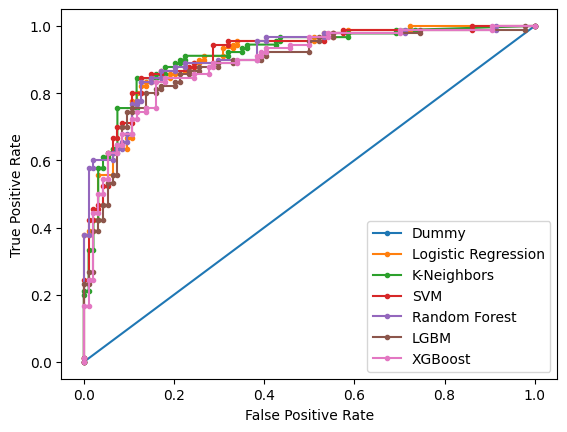

In [ ]:
for name, model in final_models.items():
    model_step = [
        ("clf", model),
    ]
    pipeline_with_model = Pipeline(
        heart_disease_pipe_base_steps + heart_disease_pipe_final_steps + model_step
    )

    pipeline_with_model.fit(X_train, y_train)
    preds_proba = pipeline_with_model.predict_proba(X_test)
    preds_proba = preds_proba[:, 1]

    lr_fpr, lr_tpr, _ = roc_curve(y_test, preds_proba)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker=".", label=name)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Conclusiones

Las curvas ROC son bastante similares, no parece haber una diferencia significativa. Por lo tanto, vamos a escoger el modelo de ***K-Nearest-Neighbours*** por ser el que más precisión y AUC obtiene sobre la muestra de test.

Como el parámetro K es 17, ante un nuevo individuo el modelo determina la presencia de enfermedad cardiovascular en base a los diagnósticos previos de los 17 individuos más cercanos. Es posible que en el contexto médico real este modelo no fuera adecuado debido a sus limitaciones a la hora de explicar las predicciones (al no tener una forma más o menos estándar de definir los feature importance no podemos achacar la decisión final a ciertas variables). Pero como estamos ante un ejercicio, vamos a continuar con la puesta en producción de este modelo por ser el que mejores resultados ha arrojado.

Este modelo nos da una precisión del 84% y un área bajo la curva de 0.84. Comparado con nuestro baseline (predecir la clase más frecuente) hemos conseguido mejorar la precisión un 53% y el AUC un 68%.